# Aula 9 - pipeline avançado e outras ferramentas

Na aula de hoje, vamos explorar os seguintes tópicos em Python:

- 1) Preenchendo NaNs com o sklearn
- 2) Utilizando dados categóricos com o sklearn
- 3) Pipelines mais completas

____

In [2]:
# importe as principais bibliotecas
from IPython.core.display import display
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

# desabilita os warnings
import warnings
warnings.filterwarnings('ignore')

Para a aula de hoje, vamos utilizar novamente a base de risco de crédito:

In [3]:
df = pd.read_csv('../datasets/german_credit_data.csv', index_col=0)

df.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,67,male,2,own,NaN,little,1169,6,radio/TV,good
1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,49,male,1,own,little,NaN,2096,12,education,good
3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,53,male,2,free,little,little,4870,24,car,bad


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Age               1000 non-null   int64 
 1   Sex               1000 non-null   object
 2   Job               1000 non-null   int64 
 3   Housing           1000 non-null   object
 4   Saving accounts   817 non-null    object
 5   Checking account  606 non-null    object
 6   Credit amount     1000 non-null   int64 
 7   Duration          1000 non-null   int64 
 8   Purpose           1000 non-null   object
 9   Risk              1000 non-null   object
dtypes: int64(4), object(6)
memory usage: 85.9+ KB


Em todas os modelos que criamos até agora, sempre nos certificamos que os dados recebidos pelos estimadores não tivessem as duas seguintes carecterísticas:

- Dados missing (NaN);
- Dados não-numéricos (str)

A esta altura, já entendemos bem o porquê disso: os estimadores dependem de algoritmos de aprendizagem, que, de uma forma ou de outra, realizam **cálculos matemáticos** no processo de aprendizagem. Sendo assim, é natural que os dados fornecidos ao estimador devem ser todos numéricos, e sem "buracos"!

Até o momento, seguimos o caminho mais simples, que é: simplesmente eliminar colunas não numéricas, e colunas/linhas que têm NaNs.

Apesar desta ser uma abordagem possível, é evidente que estamos **jogando informação fora**. Deve haver alguma forma menos drástica de resolver o problema, não é mesmo?

E é isso que aprenderemos a fazer na aula de hoje, utilizando as ferramentas do sklearn!

### Processando a base inteira (Data Leak)

In [5]:
X_cat = df.select_dtypes(exclude=np.number).drop('Risk', axis=1)
X_cat.head()

,Sex,Housing,Saving accounts,Checking account,Purpose
0,male,own,NaN,little,radio/TV
1,female,own,little,moderate,radio/TV
2,male,own,little,NaN,education
3,male,free,little,little,furniture/equipment
4,male,free,little,little,car


In [6]:
na_columns = X_cat.isnull().sum()[X_cat.isnull().sum() > 0].index
X_cat.isnull().sum()

Sex                   0
Housing               0
Saving accounts     183
Checking account    394
Purpose               0
dtype: int64

In [15]:
X_cat['Housing'].astype('category').cat.codes.value_counts()

1    713
2    179
0    108
dtype: int64

In [8]:
X_cat[na_columns] = X_cat[na_columns].fillna('unknow')
pd.get_dummies(X_cat)

,Sex_female,Sex_male,Housing_free,Housing_own,Housing_rent,Saving accounts_little,Saving accounts_moderate,Saving accounts_quite rich,Saving accounts_rich,Saving accounts_unknow,...,Checking account_rich,Checking account_unknow,Purpose_business,Purpose_car,Purpose_domestic appliances,Purpose_education,Purpose_furniture/equipment,Purpose_radio/TV,Purpose_repairs,Purpose_vacation/others
0,0,1,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
1,1,0,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,0,1,0,1,0,1,0,0,0,0,...,0,1,0,0,0,1,0,0,0,0
3,0,1,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,0,1,1,0,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,1,0,0,1,0,1,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0
996,0,1,0,1,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
997,0,1,0,1,0,1,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0
998,0,1,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


### Fazendo o pré-processamento correto

Antes de avançarmos, vamos fazer o train-test split -- mas desta vez com todas as features, bem como dados missing!

In [9]:
from sklearn.model_selection import train_test_split

X = df.drop('Risk', axis=1)
y = df['Risk']

X_train, X_test, y_train, y_test =  train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

## <span style='color:Gold'>1) Preenchendo NaNs com o sklearn



No submódulo [sklearn.impute](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.impute), existem algumas classes que são utilizadas para a o preenchimento (input) de dados NaN.

Sugiro a leitura do [User Guide](https://scikit-learn.org/stable/modules/impute.html) para maiores detalhes sobre os inputers.

Vamos utilizar o [SimpleImputer](https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html#sklearn.impute.SimpleImputer), que preenche os dados de uma coluna a partir de estatísticas descritivas dos dados naquela coluna -- no nosso caso, as colunas com NaNs são colunas categóricas. Portanto, os NaNs serão preenchidos **com a moda** de cada coluna!

Os inputers se comportam como transformers, no que diz respeito aos métodos `.fit()` e `.transform()`. Por este motivo, aqui também é muito importante que eles **sejam fitados apenas nos dados de treino!**. 

O Pipeline irá garantir isso pra gente depois, automaticamente!

In [10]:
from sklearn.impute import SimpleImputer

si_constant = SimpleImputer(strategy='constant', fill_value='unknow').fit(X_train)
si_mode = SimpleImputer(strategy='most_frequent').fit(X_train)

In [11]:
X_train_imputed_constant = pd.DataFrame(si_constant.transform(X_train), columns=X_train.columns)
X_train_imputed_mode = pd.DataFrame(si_mode.transform(X_train), columns=X_train.columns)
display(X_train_imputed_constant.head())
display(X_train_imputed_mode.head())

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose
0,26,female,3,rent,little,unknow,4530,30,radio/TV
1,41,male,2,own,moderate,moderate,2503,30,business
2,22,female,2,own,little,moderate,1567,12,radio/TV
3,35,male,2,own,unknow,moderate,3976,21,furniture/equipment
4,22,female,2,rent,moderate,unknow,2301,9,furniture/equipment


,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose
0,26,female,3,rent,little,little,4530,30,radio/TV
1,41,male,2,own,moderate,moderate,2503,30,business
2,22,female,2,own,little,moderate,1567,12,radio/TV
3,35,male,2,own,little,moderate,3976,21,furniture/equipment
4,22,female,2,rent,moderate,little,2301,9,furniture/equipment


In [12]:
display(X_train_imputed_constant['Saving accounts'].value_counts())
display(X_train_imputed_mode['Saving accounts'].value_counts())

little        480
unknow        149
moderate       87
quite rich     48
rich           36
Name: Saving accounts, dtype: int64

little        629
moderate       87
quite rich     48
rich           36
Name: Saving accounts, dtype: int64

Na prática, vamos **adicionar o inputer como parte do nosso Pipeline**, e, com isso, garantiremos que o data leakage não vai acontecer! ;)

Obs.: como fizemos, o sklearn irá transformar todas as colunas em dados do tipo `object`. 

Isso porque o inputer foi fitado **com todas as colunas**, o que inclui as numéricas também.

Para evitar isso, seria legal usar o inputer **apenas em colunas determinadas**. Faremos isso com a Pipeline! ;)

____

## <span style='color:Gold'>2) Utilizando dados categóricos com o sklearn  



No módulo 3, aprendemos como numerizar features categóricas usando o `pd.get_dummies()`, bem como usando o `.astype("category").cat.codes`.

Agora, com o objetivo de incluir essas estratégias de pré-processamento no pipeline, é importante que também usemos o sklearn pra fazer isso!

As classes relevantes são:

- [OneHotEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html#sklearn.preprocessing.OneHotEncoder) - faz o one-hot encoding;
- [OrdinalEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OrdinalEncoder.html#sklearn.preprocessing.OrdinalEncoder) - faz o categorical (ordinal) encoding.

Ambos os encoders também funcionam com os métodos `.fit()` e `.transform()`, então também é uma boa ideia colocá-los **como etapa inicial da Pipeline**.

Mas, para ilustrar seu funcionamento, vejamos a seguir.

In [16]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 800 entries, 675 to 695
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Age               800 non-null    int64 
 1   Sex               800 non-null    object
 2   Job               800 non-null    int64 
 3   Housing           800 non-null    object
 4   Saving accounts   651 non-null    object
 5   Checking account  477 non-null    object
 6   Credit amount     800 non-null    int64 
 7   Duration          800 non-null    int64 
 8   Purpose           800 non-null    object
dtypes: int64(4), object(5)
memory usage: 62.5+ KB


In [17]:
X_train_imputed_mode.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Age               800 non-null    object
 1   Sex               800 non-null    object
 2   Job               800 non-null    object
 3   Housing           800 non-null    object
 4   Saving accounts   800 non-null    object
 5   Checking account  800 non-null    object
 6   Credit amount     800 non-null    object
 7   Duration          800 non-null    object
 8   Purpose           800 non-null    object
dtypes: object(9)
memory usage: 56.4+ KB


(Primeiramente, vamos "corrigir" a codificação como object das colunas, induzida pelo inputer)

In [18]:
"Age Job Duration".split()

['Age', 'Job', 'Duration']

In [20]:
X_train_imputed_mode[['Age', 'Job', 'Duration', 'Credit amount']] = X_train_imputed_mode[['Age', 'Job', 'Duration', 'Credit amount']].astype(int)

In [22]:
X_train_imputed_mode.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Age               800 non-null    int64 
 1   Sex               800 non-null    object
 2   Job               800 non-null    int64 
 3   Housing           800 non-null    object
 4   Saving accounts   800 non-null    object
 5   Checking account  800 non-null    object
 6   Credit amount     800 non-null    int64 
 7   Duration          800 non-null    int64 
 8   Purpose           800 non-null    object
dtypes: int64(4), object(5)
memory usage: 56.4+ KB


Agora sim, vamos pros encoders!

In [23]:
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder

In [25]:
encoder_oh = OneHotEncoder().fit(X_train_imputed_mode.select_dtypes(exclude=np.number))

encoder_oe = OrdinalEncoder().fit(X_train_imputed_mode.select_dtypes(exclude=np.number))

In [31]:
X_train_imputed_mode.select_dtypes(exclude=np.number)

,Sex,Housing,Saving accounts,Checking account,Purpose
0,female,rent,little,little,radio/TV
1,male,own,moderate,moderate,business
2,female,own,little,moderate,radio/TV
3,male,own,little,moderate,furniture/equipment
4,female,rent,moderate,little,furniture/equipment
...,...,...,...,...,...
795,male,own,moderate,moderate,car
796,male,own,little,moderate,business
797,female,own,little,little,education
798,male,free,little,little,car


In [27]:
pd.DataFrame(encoder_oh.transform(X_train_imputed_mode.select_dtypes(exclude=np.number)).toarray())

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
795,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
796,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
797,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
798,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [28]:
aux = pd.DataFrame(encoder_oe.transform(X_train_imputed_mode.select_dtypes(exclude=np.number)))

aux

,0,1,2,3,4
0,0.0,2.0,0.0,0.0,5.0
1,1.0,1.0,1.0,1.0,0.0
2,0.0,1.0,0.0,1.0,5.0
3,1.0,1.0,0.0,1.0,4.0
4,0.0,2.0,1.0,0.0,4.0
...,...,...,...,...,...
795,1.0,1.0,1.0,1.0,1.0
796,1.0,1.0,0.0,1.0,0.0
797,0.0,1.0,0.0,0.0,3.0
798,1.0,0.0,0.0,0.0,1.0


In [29]:
aux[1].value_counts()

1.0    579
2.0    139
0.0     82
Name: 1, dtype: int64

In [30]:
X_train["Housing"].value_counts()

own     579
rent    139
free     82
Name: Housing, dtype: int64

Na prática, vamos deixar esta etapa pro Pipeline também! :)

É isso que faremos agora! Vamos construir uma pipeline mais completa, que vai **incluir todos os pré-processamentos**, tratando separadamente features numéricas de features categóricas!

___________

## <span style='color:Gold'>3) Pipelines mais completas

Veremos agora como construir pipelines mais completas!

Pra fazer isso, vai ser muito importante que usemos também o [ColumnTransformer](https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html).

Vamos ver na prática como funciona!!

In [39]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [40]:
pipeline_num_features = Pipeline([
    ('impute_num', SimpleImputer(strategy='mean')),
    ('std', StandardScaler())
])

numeric_features = X_train.select_dtypes(include=np.number).columns.tolist()
numeric_features

['Age', 'Job', 'Credit amount', 'Duration']

In [42]:
pipeline_categorical_features = Pipeline([
    ('impute_cat', SimpleImputer(strategy='constant', fill_value='unknow')),
    ('onehot', OneHotEncoder())
])

categorical_features = X_train.select_dtypes(exclude=np.number).columns.tolist()
categorical_features

['Sex', 'Housing', 'Saving accounts', 'Checking account', 'Purpose']

In [43]:
pre_processing = ColumnTransformer([
    ('numeric_transformer', pipeline_num_features, numeric_features),
    ('categorical_transformer', pipeline_categorical_features ,categorical_features)
])

In [48]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold, GridSearchCV

In [ ]:
# final pipeline
pipeline = Pipeline([
    ('pre_processing', pre_processing),
    ('dt', DecisionTreeClassifier(random_state=42))
])

params_grid_dt = {
                "dt__criterion" : ["gini", "entropy"],
                  "dt__splitter" : ["best", "random"],
                  "dt__max_depth" : range(2, 11)
                } 

splitter = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_dt = GridSearchCV(estimator=pipeline,
                       param_grid=params_grid_dt,
                       scoring="f1_weighted",
                       cv=splitter,
                       verbose=10)

grid_dt.fit(X_train, y_train)

Exibindo novamente as métricas de avaliação (pq na célula acima se perdeu devido ao verbose...)

In [56]:
grid_dt.best_params_

{'dt__criterion': 'entropy', 'dt__max_depth': 5, 'dt__splitter': 'random'}

In [51]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report


Métricas de avaliação de treino:
[[157  83]
 [114 446]]


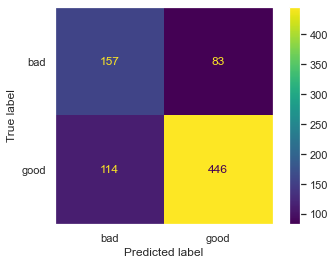

              precision    recall  f1-score   support

         bad       0.58      0.65      0.61       240
        good       0.84      0.80      0.82       560

    accuracy                           0.75       800
   macro avg       0.71      0.73      0.72       800
weighted avg       0.76      0.75      0.76       800


Métricas de avaliação de teste:
[[ 37  23]
 [ 37 103]]


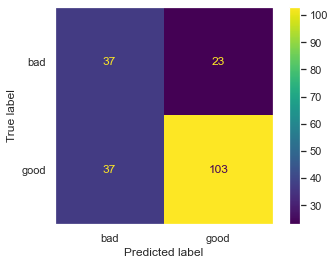

              precision    recall  f1-score   support

         bad       0.50      0.62      0.55        60
        good       0.82      0.74      0.77       140

    accuracy                           0.70       200
   macro avg       0.66      0.68      0.66       200
weighted avg       0.72      0.70      0.71       200



In [57]:
# ============================================

print("\nMétricas de avaliação de treino:")

y_pred_train = grid_dt.predict(X_train)

print(confusion_matrix(y_train, y_pred_train))
ConfusionMatrixDisplay.from_predictions(y_train, y_pred_train)
plt.grid(False)
plt.show()

print(classification_report(y_train, y_pred_train))

# ============================================

print("\nMétricas de avaliação de teste:")

y_pred_test = grid_dt.predict(X_test)

print(confusion_matrix(y_test, y_pred_test))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test)
plt.grid(False)
plt.show()

print(classification_report(y_test, y_pred_test))

_________

Uma última coisa: vamos generalizar ainda mais a pipeline!!

Pras features não-numéricas, já sabemos que podemos fazer duas codificações diferentes para numerizá-las (onehot e ordinal).

Até o momento, usamos uma abordagem ou a outra. Mas, por que não usar **ambas**?

O ColumnTransformer permite que façamos isso também!! :D

Lembrem-se que sempre utilizamo sum codificação ordinal, estamos **adicionando um viés ordinal**, que pode ser desejado ou indesejado, dependendo da feature a ser codificada!

Por isso, é importante analisar as features categóricas separadamente, e processar as colunas separadamente!

__________

Agora sim, ganhamos um poder enorme! 

Com o pipeline mais genérico que acabamos de conhecer, agora somos capazes de criar modelos que se utilizam de toda a informação disponível, e de maneiras diferentes! Muito legal, não é mesmo? 

Aproveite estas novas ferramentas incríveis que estão à sua disposição! Explore suas aplicações, e pratique muito!